In [48]:
# reload
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import funPlots as fplot

import seaborn as sns
from scipy.stats import entropy

def load_matplotlib_local_fonts():
    from matplotlib import font_manager
    
    font_path = '/home/barzon/Avenir.ttc'
    
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    #  Set it as default matplotlib font
    plt.rcParams.update({
        'font.sans-serif': prop.get_name(),
    })
    
load_matplotlib_local_fonts()

fplot.master_format(ncols = 2, nrows = 1)

In [2]:
from utils.simulation import *
from utils.mutual import *
from utils.analytical import *

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


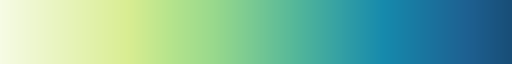

In [3]:
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ["#F6FBE4", "#ECF6C9", "#E3F2AE", "#d9ed92", "#b5e48c", "#99d98c",
          "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77"]
nodes = np.linspace(0, 1, len(colors))
cmap_SR = LinearSegmentedColormap.from_list("cmap_SR", list(zip(nodes, colors)))
cmap_SR.set_bad(color='w')
cmap_SR

In [4]:
data_folder = 'data/'

my_cmap_continuous = sns.color_palette('mako_r', as_cmap=True)

colors = ("#76c893", "#184e77")
labels = ('$E$', '$I$')

## Input projection

In [10]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, hs])

D = 0.5
r = 1

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [11]:
### Define grid params
kmin, kmax = 0.01, 5
wmin, wmax = 0.01, 10

nk, nw = int(1e2), int(1e2)

k_list, w_list = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ws_ts, Ks_ts = np.meshgrid(w_list, k_list)

print(w_list.size * k_list.size)

10000


In [ ]:
### Compute mutual
mutuals = mutual_information_slowjumps(w_list, k_list, r, D, hs, p_stat, nsamples = int(1e4))
np.save(data_folder+'mutual_importance_sampling_global_input.npy', mutuals)

In [ ]:
mutuals = np.load(data_folder+'mutual_importance_sampling_global_input.npy')

In [9]:
kmin, kmax = 0.01, 5
wmin, wmax = 1, 10
sigmah = 1

nk, nw = int(1e3), int(5e2)

ws = np.linspace(wmin, wmax, nw)
Ks = np.zeros((nw, nk))
Ws = np.zeros((nw, nk))

for idx_w, w in enumerate(ws):
    kcrit = 1 - 1/w
    if w <=1:
        k_list = np.linspace(kmin, kmax, nk)
    else:
        k_list = np.geomspace(1e-12, kcrit/2, 500) + kcrit
        k_list = np.concatenate([np.linspace(kcrit*(1 + 1/2), kmax, nk - 500), k_list])
    Ks[idx_w] = np.sort(k_list)
    Ws[idx_w] = w

unstable = np.where(1 + Ws*(Ks-1)<=0)

Istat = np.zeros(Ks.shape)
SDer = np.zeros(Ks.shape)

for idx_w, w in enumerate(ws):
    for idx_k, k in enumerate(Ks[idx_w]):
        if 1 + w*(k-1)<=0:
            Istat[idx_w, idx_k] = np.nan
            SDer[idx_w, idx_k] = np.nan
        else:
            Istat[idx_w, idx_k] = mutual_stat_input_global(w, k, sigmah)
            SDer[idx_w, idx_k] = mutual_second_der_global(w, k, sigmah)

Istat /= np.log(2)
SDer /= np.log(2)

/tmp/ipykernel_12803/3120085344.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = False)
/tmp/ipykernel_12803/3120085344.py:57: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = False)


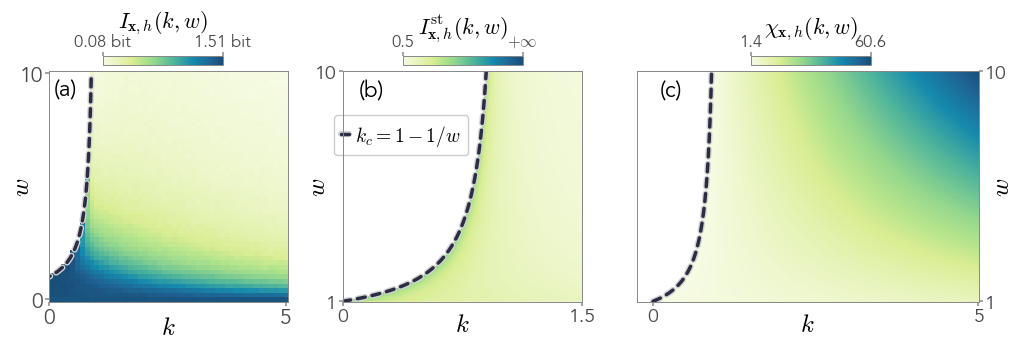

In [61]:
fig, axs = plt.subplot_mosaic([["CP", "cp_ist","cp_chi"]],
                               figsize = (12, 3),
                               gridspec_kw = {'width_ratios': [.7, .7, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.3)

axs["CP"].pcolor(Ks_ts, Ws_ts, mutuals.T/np.log(2), cmap=cmap_SR, rasterized = True, shading = 'auto')
axs["CP"].plot(1-1/w_list, w_list, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()], dashes=[2.3, 2])

axs["CP"].set_xlim(kmin,None)

axs["CP"].set_xlabel('$k$', labelpad = -10, fontsize = 18)
axs["CP"].set_ylabel('$w$', labelpad = -12, fontsize = 18)
axs["CP"].set_xticks([0, 5])
axs["CP"].set_yticks([0, 10])

legend = axs["CP"].legend(fontsize = 14, bbox_to_anchor=(1.15, .85), loc='upper left', framealpha=1.).set_zorder(1000)

cax = fig.add_axes([0.17, 0.9, 0.1, 0.03])
cbar = plt.colorbar(axs["CP"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_label(label = r'$I_{\mathbf{x},h} (k, w)$', fontsize = 16)

min_mutual = np.nanmin(mutuals)/np.log(2)
max_mutual = np.nanmax(mutuals)/np.log(2)

cbar.set_ticks([min_mutual , max_mutual])
cbar.set_ticklabels([f'{min_mutual:.2f} bit', f'{max_mutual:.2f} bit'], fontsize = 12)

axs["cp_chi"].pcolormesh(Ks, Ws, SDer, cmap=cmap_SR, rasterized = False)
axs["cp_chi"].set_xlabel('$k$', labelpad = -10, fontsize = 18)
axs["cp_chi"].set_ylabel('$w$', labelpad = -12, fontsize = 18)
#axs["cp_chi"].set_aspect(0.5)
axs["cp_chi"].set_yticks([1, 10])
axs["cp_chi"].set_xticks([0, 5])
axs["cp_chi"].tick_params(axis='both', which='major', labelsize=14)

axs["cp_chi"].yaxis.set_label_position("right")
axs["cp_chi"].yaxis.tick_right()

axs["cp_chi"].plot(1-1/ws, ws, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()], dashes=[2.3, 2])

chi_max = np.nanmax(SDer)
chi_min = np.nanmin(SDer)

cax = fig.add_axes([0.71, 0.9, 0.1, 0.03])
cbar = plt.colorbar(axs["cp_chi"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([chi_min, chi_max])
cbar.set_ticklabels([f'{chi_min:.1f}', f'{chi_max:.1f}'], fontsize = 12)
cbar.set_label(r'$\chi_{\mathbf{x},h}(k, w)$', labelpad = 0, fontsize = 16)

axs["cp_ist"].pcolormesh(Ks, Ws, np.log10(Istat), cmap=cmap_SR, rasterized = False)
axs["cp_ist"].set_xlabel('$k$', labelpad = -10, fontsize = 18)
axs["cp_ist"].set_ylabel('$w$', labelpad = -12, fontsize = 18)
#axs["cp_ist"].set_aspect(0.3)
axs["cp_ist"].set_xlim(0.0,1.5)
axs["cp_ist"].set_xticks([0, 1.5])
axs["cp_ist"].set_xticklabels(["0", "1.5"])
axs["cp_ist"].set_yticks([1, 10])
axs["cp_ist"].tick_params(axis='both', which='major', labelsize=14)

axs["cp_ist"].plot(1-1/ws, ws, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()], dashes=[2.3, 2])

ist_max = np.nanmax(np.log10(Istat))
ist_min = np.nanmin(np.log10(Istat))

cax = fig.add_axes([0.42, 0.9, 0.1, 0.03])
cbar = plt.colorbar(axs["cp_ist"].collections[0], cax=cax, orientation='horizontal')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
cbar.set_ticks([ist_min, ist_max])
cbar.set_ticklabels([f'{10**ist_min:.1f}', '$+\infty$'], fontsize = 12)
cbar.set_label(r'$I_{\mathbf{x},h}^\mathrm{st} (k, w)$', labelpad = 0, fontsize = 16)

axs["CP"].text(0.1,9,'(a)', fontsize=16)
axs["cp_ist"].text(0.1,9,'(b)', fontsize=16)
axs["cp_chi"].text(0.1,9,'(c)', fontsize=16)

plt.savefig('figures/Figure_suppl_input_projection.png', dpi = 300, bbox_inches = 'tight')

plt.show()

# Linear vs nonlinear

In [5]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 2.
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    D = 0.5 #0.001 #0.001 #0.05
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r, 'D': D}

#### Example of trajectory for slow timescale

In [6]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [31]:
inputs_slow, states_slow = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)
inputs_slow_nonlinear, states_slow_nonlinear = simulate_coupled_system(info_system, info_input, info_simulation, seed=2, linear=False)

#### Example of trajectory for fast timescale

In [32]:
### Info input
M = 3
tau_h = 8
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [33]:
inputs_fast, states_fast = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)
inputs_fast_nonlinear, states_fast_nonlinear = simulate_coupled_system(info_system, info_input, info_simulation, seed=2, linear=False)

#### Make figure

In [40]:
t_min = 10000

h_fast, bins_fast_x, bins_fast_y = np.histogram2d(states_fast[t_min:,0], states_fast[t_min:,1],
                                                  bins = 100, density=True)
h_slow, bins_slow_x, bins_slow_y = np.histogram2d(states_slow[t_min:,0], states_slow[t_min:,1],
                                                  bins = 100, density=True)

h_max = max(h_fast.max(), h_slow.max())

h_fast, bins_fast_x, bins_fast_y = np.histogram2d(states_fast_nonlinear[t_min:,0], states_fast_nonlinear[t_min:,1],
                                                  bins = 100, density=True)
h_slow, bins_slow_x, bins_slow_y = np.histogram2d(states_slow_nonlinear[t_min:,0], states_slow_nonlinear[t_min:,1],
                                                  bins = 100, density=True)

h_max_nonlinear = max(h_fast.max(), h_slow.max())

In [35]:
idx_start = 175000
idx_end = 255000

Nsteps = idx_end - idx_start

Time = np.arange(Nsteps)*dt

In [61]:
plt.rcParams.update({'font.size': 16})

/tmp/ipykernel_135924/3446248280.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


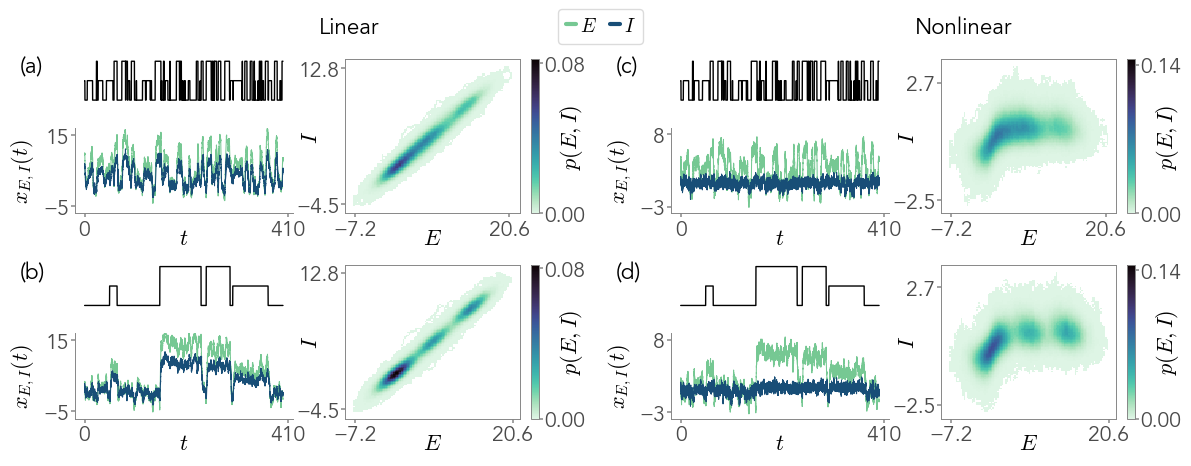

In [136]:
fig, axs = plt.subplot_mosaic([["lin", "lin", ".", "nonlin", "nonlin"],
                               ["hf", "pf", ".", "hf_nl", "pf_nl"],
                               ["tf", "pf", ".", "tf_nl", "pf_nl"],
                               [".", ".", ".", ".", "."],
                               ["hs", "ps", ".", "hs_nl", "ps_nl"],
                               ["ts", "ps", ".", "ts_nl", "ps_nl"]], figsize = (14, 5),
                               gridspec_kw = {'height_ratios': [0.001,0.5, 1, 0.001, 0.5, 1], 'width_ratios': [1, 1, 0.01, 1, 1]})

plt.subplots_adjust(hspace = .6, wspace = 0.3)

axs['lin'].axis('off')
axs['lin'].text(0.5,0.,'Linear')

axs['nonlin'].axis('off')
axs['nonlin'].text(0.5,0.,'Nonlinear')

########### LINEAR ###########
for ax in [axs["tf"], axs["ts"]]:
    ax.spines[['top','right']].set_visible(False)
    ax.set_xticks([0, 410])
    ax.set_yticks([-5, 15])
    ax.set_xlabel('$t$', labelpad = -10)
    ax.set_ylabel('$x_{E, I}(t)$')
    ax.set_ylim(-7, 17)

for ax in [axs["hf"], axs["hs"]]:
    ax.axis('off')

axs["hf"].plot(Time, hs[0][inputs_fast][idx_start:idx_end], c = 'k', lw = 1)
axs["hs"].plot(Time, hs[0][inputs_slow][idx_start:idx_end], c = 'k', lw = 1)

for idx, state in enumerate(states_fast.T):
    axs["tf"].plot(Time, state[idx_start:idx_end], label=labels[idx],
                   c=colors[idx], lw = 0.75)

leg = axs["tf"].legend(ncols = 2, bbox_to_anchor = (2.65,2.5), loc = "upper right", fontsize = 14, handlelength = 0.5,
                 handletextpad = 0.2, columnspacing = 0.7)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)


for idx, state in enumerate(states_slow.T):
    axs["ts"].plot(Time, state[idx_start:idx_end], label=labels[idx],
                   c=colors[idx], lw = 0.75)
    
sns.histplot(x=states_fast[t_min:,0], y=states_fast[t_min:,1], bins=100, ax=axs["pf"],
             cmap='mako_r', stat='density', cbar=True, vmin = 0, vmax = h_max,
             rasterized = True)

sns.histplot(x=states_slow[t_min:,0], y=states_slow[t_min:,1], bins=100, ax=axs["ps"],
                cmap='mako_r', stat='density', cbar=True, vmin = 0, vmax = h_max,
                rasterized = True)

for ax in [axs["pf"], axs["ps"]]:
    ax.set_xlabel(labels[0], labelpad = -10)
    ax.set_ylabel(labels[1], labelpad = -20)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, np.round(h_max, 2)])
    cbar.set_label(r'$p(E, I)$', labelpad = -20)

    ax.set_xticks([-7.2, 20.6])
    ax.set_yticks([-4.5, 12.8])
    
########### NONLINEAR ###########
for ax in [axs["tf_nl"], axs["ts_nl"]]:
    ax.spines[['top','right']].set_visible(False)
    ax.set_xticks([0, 410])
    ax.set_yticks([-3, 8])
    ax.set_xlabel('$t$', labelpad = -10)
    ax.set_ylabel('$x_{E, I}(t)$')
    ax.set_ylim(-4, 9)


for ax in [axs["hf_nl"], axs["hs_nl"]]:
    ax.axis('off')

axs["hf_nl"].plot(Time, hs[0][inputs_fast][idx_start:idx_end], c = 'k', lw = 1)
axs["hs_nl"].plot(Time, hs[0][inputs_slow][idx_start:idx_end], c = 'k', lw = 1)

for idx, state in enumerate(states_fast_nonlinear.T):
    axs["tf_nl"].plot(Time, state[idx_start:idx_end], label=labels[idx],
                   c=colors[idx], lw = 0.75)

#axs["tf_nl"].legend(ncols = 2, bbox_to_anchor = (-0.5,2), loc = "upper left", fontsize = 14, handlelength = 0.5,
#                 handletextpad = 0.2, columnspacing = 0.7)

for idx, state in enumerate(states_slow_nonlinear.T):
    axs["ts_nl"].plot(Time, state[idx_start:idx_end], label=labels[idx],
                   c=colors[idx], lw = 0.75)
    
sns.histplot(x=states_fast[t_min:,0], y=states_fast_nonlinear[t_min:,1], bins=100, ax=axs["pf_nl"],
             cmap='mako_r', stat='density', cbar=True, vmin = 0, vmax = h_max_nonlinear,
             rasterized = True)

sns.histplot(x=states_slow[t_min:,0], y=states_slow_nonlinear[t_min:,1], bins=100, ax=axs["ps_nl"],
                cmap='mako_r', stat='density', cbar=True, vmin = 0, vmax = h_max_nonlinear,
                rasterized = True)

for ax in [axs["pf_nl"], axs["ps_nl"]]:
    ax.set_xlabel(labels[0], labelpad = -10)
    ax.set_ylabel(labels[1], labelpad = -20)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.14])
    cbar.set_label(r'$p(E, I)$', labelpad = -20)

    ax.set_xticks([-7.2, 20.6])
    ax.set_yticks([-2.5, 2.7])
    
axs['hf'].text(-130,3.5,'(a)')
axs['hs'].text(-130,3.5,'(b)')
axs['hf_nl'].text(-130,3.5,'(c)')
axs['hs_nl'].text(-130,3.5,'(d)')
    
plt.savefig('figures/Figure_suppl_linear_nonlinear_trajectories.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Nonlinear - delta_h = 1

In [80]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 1.
D = 0.05
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [81]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [2, 4, 6] #[1, 2, 4, 6]

res_linear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear[ih,iw] = tmp_res_linear
        res_nonlinear[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

#### Nonlinear - delta_h = 0.15

In [82]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = 0.15
D = 0.001
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [83]:
ks = np.load(data_folder+f'k_list_nonlinear.npy')
ks_large = np.load(data_folder+f'k_list_nonlinear_large.npy')
n_runs = 10
tau_hs = [1000, 250] #[1000, 500, 250]
ws = [2, 4, 6] #[1, 2, 4, 6]

res_linear_smallh = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))
res_nonlinear_smallh = np.zeros((len(tau_hs), len(ws), ks.size, n_runs))

for ih, tau_h in enumerate(tau_hs):
    for iw, w in enumerate(ws):
        tmp_res_linear = np.load(f'data/mutual_linear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        tmp_res_nonlinear = np.load(f'data/mutual_nonlinear_w_{w}_tau_{tau_h}_dh_{delta_h}_k_{ks[0]}_{ks[-1]}_{ks.size}.npy')
        
        res_linear_smallh[ih,iw] = tmp_res_linear
        res_nonlinear_smallh[ih,iw] = tmp_res_nonlinear
        
mi_imp_samp = np.zeros((len(ws), ks_large.size))

for i, w in enumerate(ws):
    mi_importance_sampling = np.load(data_folder+f'mutual_importance_sampling_fixedw{w}_deltah_{delta_h}_D_{D}.npy')
    mi_imp_samp[i] = mi_importance_sampling

#### Make figure

In [93]:
plt.rcParams.update({'font.size': 16})

/tmp/ipykernel_12803/1512632362.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ks, res_nonlinear_smallh[j,i].mean(axis=1), c=cmaps_nonlin(j), s = 50, zorder = np.inf,
/tmp/ipykernel_12803/1512632362.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ks, res_nonlinear[j,i].mean(axis=1), c=cmaps_nonlin(j), s = 50, zorder = np.inf,
/tmp/ipykernel_12803/1512632362.py:84: UserWarning: Tight layout 

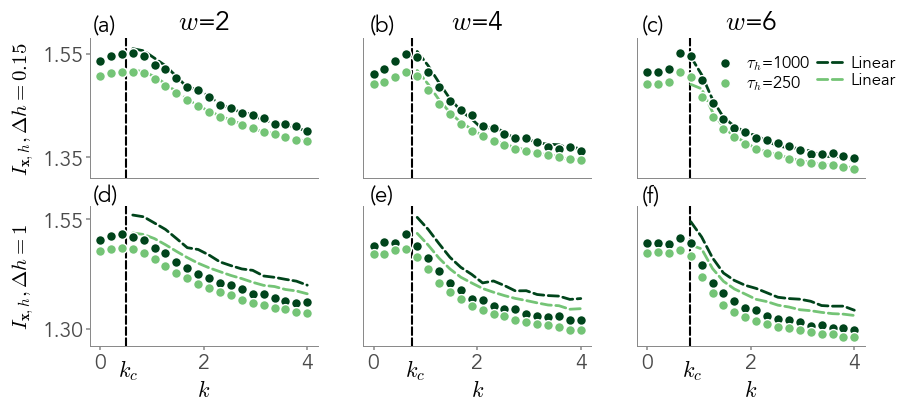

In [219]:
figsize=(10,4)
cmaps_lin = plt.get_cmap('Blues_r',len(tau_hs)+1)
cmaps_nonlin = plt.get_cmap('Greens_r',len(tau_hs)+1)

plt.figure(figsize=figsize)

######### SMALL dh #########
for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    ax = plt.subplot(2,len(ws),i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.scatter(ks, res_nonlinear_smallh[j,i].mean(axis=1), c=cmaps_nonlin(j), s = 50, zorder = np.inf,
                       ec = "w", lw = 1, label = r'$\tau_h$='+str(tau_h))
        plt.plot(ks, res_linear_smallh[j,i].mean(axis=1), label='Linear', color=cmaps_nonlin(j),
                lw = 2, ls = '--')
    
    #plt.plot(ks_large, mi_importance_sampling / np.log(2), '-', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    #plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.title(f'$w$={w}')
    
    plt.xticks([])
    
    if i==0:
        #plt.legend(ncol=2)
        plt.ylabel('$I_{\mathbf{x},h}, \Delta h = 0.15$', labelpad=5, fontsize = 15)
        plt.yticks([1.35, 1.55])
    else:
        plt.yticks([])
        
    if i==2:
        ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        order = [0, 2, 1, 3]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=[1.2,1.],
                  fontsize = 12, loc = 'upper right', handlelength = 1.5, handletextpad = 0.5, frameon = False, ncol=2)
        
    plt.ylim([1.31, 1.58])
        
######### LARGE dh #########
for i, w in enumerate(ws):
    mi_importance_sampling = mi_imp_samp[i]

    #plt.figure(figsize=(6,3))
    ax = plt.subplot(2,len(ws),len(ws)+i+1)
    
    for j, tau_h in enumerate(tau_hs):
        plt.scatter(ks, res_nonlinear[j,i].mean(axis=1), c=cmaps_nonlin(j), s = 50, zorder = np.inf,
                       ec = "w", lw = 1, label = r'$\tau_h$='+str(tau_h))
        plt.plot(ks, res_linear_smallh[j,i].mean(axis=1), label=r'$\tau_h$='+str(tau_hs[j]), color=cmaps_nonlin(j),
                lw = 2, ls = '--')
    
    #plt.plot(ks_large, mi_importance_sampling / np.log(2), '-', label=r'$\tau_{input}\gg \tau$', c='k', zorder=0)

    plt.axvline(1-1/w, c='k', ls='--', zorder=-1)
    plt.text(1-1/w-0.15, 1.19, r'$k_c$')
    #plt.axhline(entropy(p_stat) / np.log(2), c='gray', ls='--', lw=3, label=r'$H_{jumps}$', zorder=1)

    plt.xlabel('$k$')
    #plt.title(f'$w$={w}')

    if i==0:
        #plt.legend()
        plt.ylabel('$I_{\mathbf{x},h}, \Delta h = 1$', labelpad=5, fontsize = 15)
        plt.yticks([1.3, 1.55])
    else:
        plt.yticks([])
    plt.ylim([1.26, 1.58])
    
x0, x1, x2 = -10.7, -5.35, -.1
y0, y1 = 1.98, 1.59
plt.text(x0, y0, '(a)')
plt.text(x1, y0, '(b)')
plt.text(x2, y0, '(c)')
plt.text(x0, y1, '(d)')
plt.text(x1, y1, '(e)')
plt.text(x2, y1, '(f)')
        
plt.tight_layout()
sns.despine()

plt.savefig('figures/Figure_suppl_linear_nonlinear.png', dpi = 300, bbox_inches = 'tight')

plt.show()        

## Effect of noise and input strength

In [62]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [63]:
### Define fix params
w = 2
k = 1.1
r = 1

### Define grid params
dhmin, dhmax = 0.001, 3
Dmin, Dmax = 0.001, 1

nh, nD = int(2e2), int(2e2)

dh_list, D_list = np.linspace(dhmin, dhmax, nh), np.linspace(Dmin, Dmax, nD)

print(dh_list.size * D_list.size)

Hs, Ds = np.meshgrid(dh_list, D_list)

40000


In [46]:
### Compute mutual
#mutuals = mutual_information_slowjumps_dh_D(w, k, r, D_list, dh_list, p_stat, nsamples = int(1e4))
#np.save(data_folder+'mutual_importance_sampling_dh_D.npy', mutuals)

In [64]:
mutuals = np.load(data_folder+'mutual_importance_sampling_dh_D.npy')

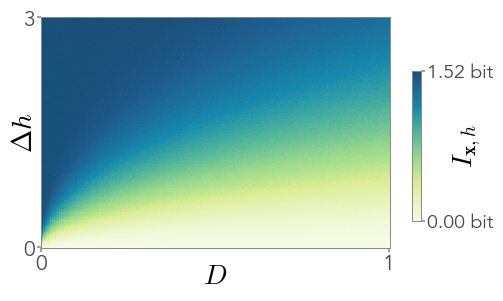

In [70]:
fig, axs = plt.subplot_mosaic([["CP"]],
                               figsize = (4.5, 3),
                               gridspec_kw = {'height_ratios': [1]})
plt.subplots_adjust(hspace=0.3, wspace=0.)
axs["CP"].pcolor(Ds, Hs, mutuals.T/np.log(2), cmap=cmap_SR, rasterized = True, shading = 'auto')
#axs["CP"].plot(1-1/w_list, w_list, ls = '--', color='#2b2d42', lw=2.5, label = "$k_c = 1 - 1/w$",
#               path_effects=[pe.Stroke(linewidth=4.5, foreground='lightgray'), pe.Normal()],
#               dashes=[2.3, 2])

axs["CP"].set_xlim(Dmin,None)

axs["CP"].set_xlabel('$D$', labelpad = -10, fontsize=20)
axs["CP"].set_ylabel('$\Delta h$', labelpad = -12, fontsize=20)
axs["CP"].set_xticks([0, D_list.max()])
axs["CP"].set_yticks([0, dh_list.max()])

#axs["CP"].legend(fontsize = 14, bbox_to_anchor=(1.05, 1.3), loc='upper left')

cax = fig.add_axes([.95, 0.2, 0.02, 0.5])
cbar = plt.colorbar(axs["CP"].collections[0], cax=cax, orientation='vertical')
cbar.set_label(label = r'$I_{\mathbf{x},h}$', fontsize=20, labelpad=-30)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

min_mutual = 0#np.nanmin(mutuals)/np.log(2)
max_mutual = np.nanmax(mutuals)/np.log(2)

cbar.set_ticks([min_mutual , max_mutual])
cbar.set_ticklabels([f'{min_mutual:.2f} bit', f'{max_mutual:.2f} bit'], fontsize = 14)

plt.savefig('figures/Figure_suppl_noise_input_strength.png', dpi = 300, bbox_inches = 'tight')

plt.show()